# DS Final

## Imports

In [3]:
import pandas as pd
import json
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, make_scorer
from sklearn.pipeline import make_pipeline
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor 
from sklearn.model_selection import KFold
import geopandas as gpd
import plotly.express as px
import tensorflow as tf

## Universal Variables

In [ ]:
HDR_JSON_PATH = 'data/hdr-data.json'
DEMOCRACY_CSV_PATH = 'data/democracy-index-eiu.csv'
HEALTHCARE_CSV_PATH = 'data/Healthcare-expenditure.csv'
FDI_CSV_PATH = 'data/foreign-direct-investment-net-inflows-as-share-of-gdp.csv'
UNEMPLOYMENT_CSV_PATH = 'data/Unemployment.csv'

## Utility Functions

In [7]:
def read_json(filepath):
    """Reads a JSON file and returns a DataFrame."""
    with open(filepath) as infile:
        return pd.read_json(infile)

def read_csv(filepath, skiprows=None):
    """Reads a CSV file and returns a DataFrame."""
    return pd.read_csv(filepath, skiprows=skiprows)

def clean_column_names(df):
    """Strips whitespace and cleans up column names."""
    df.columns = df.columns.str.strip()
    return df

def melt_dataframe(df, id_vars, var_name, value_name):
    """Melts a DataFrame into a long format."""
    return pd.melt(df, id_vars=id_vars, var_name=var_name, value_name=value_name)

def pivot_dataframe(df, index, columns, values):
    """Pivots a DataFrame into a wide format."""
    return df.pivot_table(index=index, columns=columns, values=values).reset_index()

def rename_columns(df, rename_dict):
    """Renames columns based on a dictionary."""
    return df.rename(columns=rename_dict)

def merge_dataframes(df1, df2, on, how='left'):
    """Merges two DataFrames."""
    return pd.merge(df1, df2, how=how, on=on)


# Preparing the Dataset

## Data Specific Functions

In [10]:
def process_hdr_data(filepath):
    df = read_json(filepath)
    df = df[['country', 'countryIsoCode', 'year', 'indicator', 'value']]
    df_pivoted = pivot_dataframe(df, index=['country', 'countryIsoCode', 
                                            'year'], columns='indicator',
                                             values='value')
    df_pivoted = rename_columns(df_pivoted, {'country': 'Country', 
                                             'countryIsoCode': 'Code', 
                                             'year': 'Year'})
    return df_pivoted

def process_democracy_data(filepath):
    df = read_csv(filepath)
    df = rename_columns(df, {'Entity': 'Country'})
    return df

def process_health_expenditure_data(filepath):
    df = read_csv(filepath, skiprows=4)
    df = clean_column_names(df)
    df_melted = melt_dataframe(
        df,
        id_vars=['Country Name', 'Country Code', 'Indicator Name', 
                 'Indicator Code'],
        var_name='Year',
        value_name='Value'
    )
    df_pivoted = pivot_dataframe(df_melted, index=['Country Name', 
                                                   'Country Code', 'Year'], 
                                 columns='Indicator Name', values='Value')
    return rename_columns(df_pivoted, {'Country Name': 'Country', 
                                       'Country Code': 'Code'})

def process_fdi_data(filepath):
    df = read_csv(filepath)
    return rename_columns(df, {'Entity': 'Country'})

def process_unemployment_data(filepath):
    df = read_csv(filepath)
    df.drop(columns=['Series Code'], inplace=True)
    df = clean_column_names(df)
    df.columns = [col.split(' ')[0] if ' [YR' in col else col for col in 
                  df.columns]
    df_melted = melt_dataframe(df, id_vars=['Country Name', 'Country Code', 
                                            'Series Name'], var_name='Year', 
                               value_name='Value')
    df_melted['Value'] = pd.to_numeric(df_melted['Value'], errors='coerce')
    df_pivoted = pivot_dataframe(df_melted, index=['Country Name', 
                                                   'Country Code', 'Year'], 
                                 columns='Series Name', values='Value')
    return rename_columns(df_pivoted, {'Country Name': 'Country', 
                                       'Country Code': 'Code'})


## Processing The Data

In [12]:
hdr_data = process_hdr_data(HDR_JSON_PATH)
democracy_data = process_democracy_data(DEMOCRACY_CSV_PATH)
health_expense_data = process_health_expenditure_data(HEALTHCARE_CSV_PATH)
fdi_data = process_fdi_data(FDI_CSV_PATH)
unemployment_data = process_unemployment_data(UNEMPLOYMENT_CSV_PATH)
    
# Ensuring 'Year' columns are of consistent type
datasets = [hdr_data, democracy_data, health_expense_data, fdi_data, 
                unemployment_data]
for df in datasets:
    if 'Year' in df.columns:
        df['Year'] = df['Year'].astype(int)

## Exploring The Datasets

### HDR Data

COLUMNS THAT HAVE LESS THAN 40% MISSING:

Index(['Country', 'Code', 'Year',
       'Adolescent Birth Rate (births per 1,000 women ages 15-19)',
       'Carbon dioxide emissions per capita (production) (tonnes)',
       'Coefficient of human inequality', 'Difference from HDI value (%)',
       'Expected Years of Schooling (years)',
       'Expected Years of Schooling, female (years)',
       'Expected Years of Schooling, male (years)',
       'Gender Development Index (value)', 'Gender Inequality Index (value)',
       'Gross National Income Per Capita (2017 PPP$)',
       'Gross National Income Per Capita, female (2017 PPP$)',
       'Gross National Income Per Capita, male (2017 PPP$)', 'HDI female',
       'HDI male', 'Human Development Index (value)', 'Inequality in eduation',
       'Inequality in income', 'Inequality in life expectancy',
       'Inequality-adjusted Human Development Index (value)',
       'Labour force participation rate, female (% ages 15 and older)',
       'Labour force participation rate, male (% ages 15 and older)',
       'Life Expectancy at Birth (years)',
       'Life Expectancy at Birth, female (years)',
       'Life Expectancy at Birth, male (years)',
       'Material footprint per capita (tonnes)',
       'Maternal Mortality Ratio (deaths per 100,000 live births)',
       'Mean Years of Schooling (years)',
       'Mean Years of Schooling, female (years)',
       'Mean Years of Schooling, male (years)', 'Overall loss (%)',
       'Planetary pressures–adjusted Human Development Index (value)',
       'Population with at least some secondary education, female (% ages 25 and older)',
       'Population with at least some secondary education, male (% ages 25 and older)',
       'Share of seats in parliament, female (% held by women)',
       'Share of seats in parliament, male (% held by men)'],
      dtype='object', name='indicator')

In [16]:
# To substitute a different data source for exploration, simply change the string located...

data_to_explore = hdr_data # < ...here

data_to_explore

indicator,Country,Code,Year,"Adolescent Birth Rate (births per 1,000 women ages 15-19)",Assets (%),Carbon dioxide emissions per capita (production) (tonnes),Child mortality (%),Coefficient of human inequality,Cooking fuel (%),Difference from HDI rank,...,Nutrition (%),Overall loss (%),Planetary pressures–adjusted Human Development Index (value),"Population with at least some secondary education, female (% ages 25 and older)","Population with at least some secondary education, male (% ages 25 and older)",Sanitation (%),School attendance (%),"Share of seats in parliament, female (% held by women)","Share of seats in parliament, male (% held by men)",Years of schooling (%)
0,Afghanistan,AFG,1990,142.960,NaN,0.189,NaN,NaN,NaN,NaN,...,NaN,NaN,0.281,1.108,7.899,NaN,NaN,NaN,NaN,NaN
1,Afghanistan,AFG,1991,147.525,NaN,0.178,NaN,NaN,NaN,NaN,...,NaN,NaN,0.289,1.221,8.138,NaN,NaN,NaN,NaN,NaN
2,Afghanistan,AFG,1992,147.521,NaN,0.123,NaN,NaN,NaN,NaN,...,NaN,NaN,0.296,1.335,8.377,NaN,NaN,NaN,NaN,NaN
3,Afghanistan,AFG,1993,147.896,NaN,0.106,NaN,NaN,NaN,NaN,...,NaN,NaN,0.304,1.449,8.616,NaN,NaN,NaN,NaN,NaN
4,Afghanistan,AFG,1994,155.669,NaN,0.094,NaN,NaN,NaN,NaN,...,NaN,NaN,0.298,1.562,8.855,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6434,Zimbabwe,ZWE,2018,98.507,NaN,0.712,NaN,28.942,NaN,NaN,...,NaN,30.142,0.556,60.982,71.707,NaN,NaN,34.286,65.714,NaN
6435,Zimbabwe,ZWE,2019,97.354,7.582,0.637,4.864,30.722,12.72,NaN,...,18.696,32.857,0.553,62.197,72.643,10.813,11.903,34.571,65.429,5.369
6436,Zimbabwe,ZWE,2020,96.180,NaN,0.501,NaN,30.558,NaN,NaN,...,NaN,32.671,0.545,63.435,73.591,NaN,NaN,34.571,65.429,NaN
6437,Zimbabwe,ZWE,2021,94.312,NaN,0.525,NaN,30.510,NaN,NaN,...,NaN,32.605,0.540,63.435,73.591,NaN,NaN,34.571,65.429,NaN


In [17]:
data_to_explore.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6439 entries, 0 to 6438
Data columns (total 53 columns):
 #   Column                                                                           Non-Null Count  Dtype  
---  ------                                                                           --------------  -----  
 0   Country                                                                          6439 non-null   object 
 1   Code                                                                             6439 non-null   object 
 2   Year                                                                             6439 non-null   int64  
 3   Adolescent Birth Rate (births per 1,000 women ages 15-19)                        6435 non-null   float64
 4   Assets (%)                                                                       136 non-null    float64
 5   Carbon dioxide emissions per capita (production) (tonnes)                        6350 non-null   float64
 6   Child mo

In [18]:
# Filter rows for a range years (currently 2013-2022)
filtered_data = data_to_explore[(data_to_explore['Year'] >= 2011) & (data_to_explore['Year'] <= 2023)]

# Step 2: Drop columns with more than 20% missing data
threshold = 0.4  # 40% missing data threshold
missing_data_ratio = filtered_data.isnull().mean()  
columns_to_keep = missing_data_ratio[missing_data_ratio <= threshold].index

# Filter the dataset
cleaned_data = filtered_data[columns_to_keep]

# Check the resulting dataset structure
print(f"Columns with less than {threshold * 100}% of data missing:")
print(cleaned_data.columns)

Columns with less than 40.0% of data missing:
Index(['Country', 'Code', 'Year',
       'Adolescent Birth Rate (births per 1,000 women ages 15-19)',
       'Carbon dioxide emissions per capita (production) (tonnes)',
       'Coefficient of human inequality', 'Difference from HDI value (%)',
       'Expected Years of Schooling (years)',
       'Expected Years of Schooling, female (years)',
       'Expected Years of Schooling, male (years)',
       'Gender Development Index (value)', 'Gender Inequality Index (value)',
       'Gross National Income Per Capita (2017 PPP$)',
       'Gross National Income Per Capita, female (2017 PPP$)',
       'Gross National Income Per Capita, male (2017 PPP$)', 'HDI female',
       'HDI male', 'Human Development Index (value)', 'Inequality in eduation',
       'Inequality in income', 'Inequality in life expectancy',
       'Inequality-adjusted Human Development Index (value)',
       'Labour force participation rate, female (% ages 15 and older)',
       '

## Merging the Datasets

In [20]:
merged_df = hdr_data
merged_df = merge_dataframes(merged_df, democracy_data, on=['Country', 'Code', 'Year'])
merged_df = merge_dataframes(merged_df, health_expense_data, on=['Country', 'Code', 'Year'])
merged_df = merge_dataframes(merged_df, fdi_data, on=['Country', 'Code', 'Year'])
merged_df = merge_dataframes(merged_df, unemployment_data, on=['Country', 'Code', 'Year'])

## More of Cleaning The Data, and Preventing Overfitting


### Step 1: Selecting only the years in the Target Dataset: 2013 - 2022


In [23]:
df_post_2013 = merged_df[(merged_df['Year'] >= 2013) & (merged_df['Year'] <= 2022)]
df_post_2013.shape

(1950, 57)

In [24]:
df_post_2013

,Country,Code,Year,"Adolescent Birth Rate (births per 1,000 women ages 15-19)",Assets (%),Carbon dioxide emissions per capita (production) (tonnes),Child mortality (%),Coefficient of human inequality,Cooking fuel (%),Difference from HDI rank,...,"Population with at least some secondary education, male (% ages 25 and older)",Sanitation (%),School attendance (%),"Share of seats in parliament, female (% held by women)","Share of seats in parliament, male (% held by men)",Years of schooling (%),Democracy score,"Current health expenditure per capita, PPP (current international $)","Foreign direct investment, net inflows (% of GDP)","Unemployment, total (% of total labor force) (modeled ILO estimate)"
23,Afghanistan,AFG,2013,106.537,NaN,0.293,NaN,34.478,NaN,NaN,...,19.714,NaN,NaN,27.635,72.365,NaN,2.48,178.079019,0.239801,7.919
24,Afghanistan,AFG,2014,101.454,NaN,0.280,NaN,34.322,NaN,NaN,...,20.528,NaN,NaN,27.635,72.365,NaN,2.77,202.261555,0.209665,7.915
25,Afghanistan,AFG,2015,97.415,2.833,0.290,10.009,34.316,10.072,NaN,...,21.342,9.960,25.740,27.445,72.555,19.249,2.77,215.725233,0.884000,9.011
26,Afghanistan,AFG,2016,94.018,NaN,0.262,NaN,34.035,NaN,NaN,...,20.263,NaN,NaN,27.445,72.555,NaN,2.55,239.188747,0.516606,10.100
27,Afghanistan,AFG,2017,90.342,NaN,0.277,NaN,34.220,NaN,NaN,...,19.184,NaN,NaN,27.445,72.555,NaN,2.55,264.543989,0.274797,11.184
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6434,Zimbabwe,ZWE,2018,98.507,NaN,0.712,NaN,28.942,NaN,NaN,...,71.707,NaN,NaN,34.286,65.714,NaN,3.16,111.078436,2.101721,6.792
6435,Zimbabwe,ZWE,2019,97.354,7.582,0.637,4.864,30.722,12.720,NaN,...,72.643,10.813,11.903,34.571,65.429,5.369,3.16,72.015965,1.142806,7.373
6436,Zimbabwe,ZWE,2020,96.180,NaN,0.501,NaN,30.558,NaN,NaN,...,73.591,NaN,NaN,34.571,65.429,NaN,3.16,60.215361,0.699033,8.621
6437,Zimbabwe,ZWE,2021,94.312,NaN,0.525,NaN,30.510,NaN,NaN,...,73.591,NaN,NaN,34.571,65.429,NaN,2.92,63.136967,0.881174,9.540


### Step 2: Finding the optimal threshold for NaN values for which we can drop a column.


#### Functions

In [27]:
def drop_nans(df, threshold):
    """
    Drops columns from a DataFrame where the number of NaN values exceeds the threshold (int).
    
    Returns a pd.DataFrame with just the columns exceeding the threshold dropped.
    """
    return df.loc[:, df.isna().sum() <= threshold]

#The below function will help identify the optimal NaN drop boundary
          
def visualize_nan_and_columns(df, thresholds):
    """
    Visualizes the relationship between NaN thresholds, number of columns left, 
    and the remaining NaN values using a dual-axis plot.

    Parameters:
        df (pd.DataFrame): The input DataFrame.
        thresholds (list[int]): A list of threshold values to test.

    Returns:
        None: Displays a dual-axis line graph.
    """
    column_counts = []
    nan_counts = []  

    for threshold in thresholds:
        reduced_df = drop_nans(df, threshold)
        column_counts.append(reduced_df.shape[1])  # Number of columns in reduced DataFrame
        nan_counts.append(reduced_df.isna().sum().sum())

   
    fig, ax1 = plt.subplots(figsize=(10, 6))

    # Number of columns left
    ax1.plot(thresholds, column_counts, color='green', marker='o', label='Columns Left')
    ax1.set_xlabel('Threshold (Maximum NaN Values Per Column)', fontsize=12)
    ax1.set_ylabel('Number of Columns Left', color='green', fontsize=12)
    ax1.tick_params(axis='y', labelcolor='green')
    ax1.grid(True)

    # Remaining NaN values
    ax2 = ax1.twinx()
    ax2.plot(thresholds, nan_counts, color='blue', marker='x', label='Remaining NaN Values')
    ax2.set_ylabel('Total Remaining NaN Values', color='blue', fontsize=12)
    ax2.tick_params(axis='y', labelcolor='blue')

    plt.title('Effect of NaN Threshold on Columns and Remaining NaNs', fontsize=14)
    ax1.legend(loc='upper left')
    ax2.legend(loc='upper right')

    # Show the plot
    plt.show()

# Thresholds from 0 to the max NaNs in increments of 100
threshold_range = range(0, df_post_2013.isna().sum().max() + 100, 100)

#### Plotting NaN threshold vs. remaining NaN values


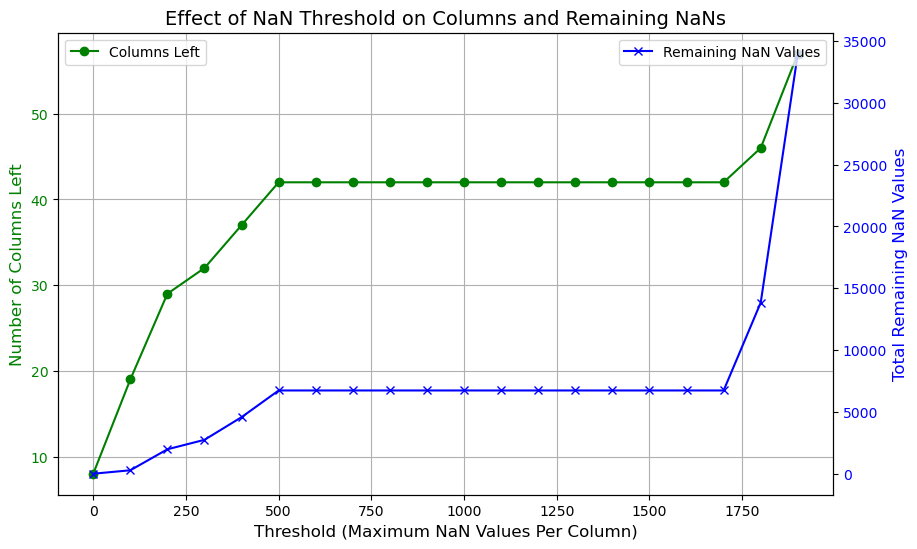

In [29]:
visualize_nan_and_columns(df_post_2013, threshold_range)

#### Based on this, we can reduce NaN values by almost 90% by setting the threshold to drop a column at 200, while still retaining over 50% of the features.

In [31]:
df_optimal = drop_nans(df_post_2013,200)
# Viable features are -
print(df_optimal.columns, len(df_optimal.columns))

Index(['Country', 'Code', 'Year',
       'Adolescent Birth Rate (births per 1,000 women ages 15-19)',
       'Carbon dioxide emissions per capita (production) (tonnes)',
       'Expected Years of Schooling (years)',
       'Expected Years of Schooling, female (years)',
       'Expected Years of Schooling, male (years)',
       'Gender Development Index (value)',
       'Gross National Income Per Capita (2017 PPP$)',
       'Gross National Income Per Capita, female (2017 PPP$)',
       'Gross National Income Per Capita, male (2017 PPP$)', 'HDI female',
       'HDI male', 'Human Development Index (value)',
       'Inequality in life expectancy',
       'Labour force participation rate, female (% ages 15 and older)',
       'Labour force participation rate, male (% ages 15 and older)',
       'Life Expectancy at Birth (years)',
       'Life Expectancy at Birth, female (years)',
       'Life Expectancy at Birth, male (years)',
       'Maternal Mortality Ratio (deaths per 100,000 live birth

### Step 3: Do a domain-specific drop, by dropping all features represented by a composite index (GDI) in the cleaned list

In [33]:
redundant_features_GDI = [
    'Expected Years of Schooling, female (years)',
    'Expected Years of Schooling, male (years)',
    'Gross National Income Per Capita, female (2017 PPP$)',
    'Gross National Income Per Capita, male (2017 PPP$)',
    'Life Expectancy at Birth, female (years)',
    'Life Expectancy at Birth, male (years)',
    'HDI female',
    'HDI male',
    'Labour force participation rate, female (% ages 15 and older)',
    'Labour force participation rate, male (% ages 15 and older)',
    'Share of seats in parliament, female (% held by women)',
    'Share of seats in parliament, male (% held by men)',
    'Population with at least some secondary education, female (% ages 25 and older)',
    'Population with at least some secondary education, male (% ages 25 and older)',
    'Mean Years of Schooling, female (years)',
    'Mean Years of Schooling, male (years)'
]

#We can also drop HDI, and focus on the effect of its composite factors, as they may not be correlated
HDI_column = ['Human Development Index (value)']

redundant_features = redundant_features_GDI + HDI_column
print(redundant_features)

['Expected Years of Schooling, female (years)', 'Expected Years of Schooling, male (years)', 'Gross National Income Per Capita, female (2017 PPP$)', 'Gross National Income Per Capita, male (2017 PPP$)', 'Life Expectancy at Birth, female (years)', 'Life Expectancy at Birth, male (years)', 'HDI female', 'HDI male', 'Labour force participation rate, female (% ages 15 and older)', 'Labour force participation rate, male (% ages 15 and older)', 'Share of seats in parliament, female (% held by women)', 'Share of seats in parliament, male (% held by men)', 'Population with at least some secondary education, female (% ages 25 and older)', 'Population with at least some secondary education, male (% ages 25 and older)', 'Mean Years of Schooling, female (years)', 'Mean Years of Schooling, male (years)', 'Human Development Index (value)']


In [34]:
df_indexed = df_optimal.drop(redundant_features, axis = 1)

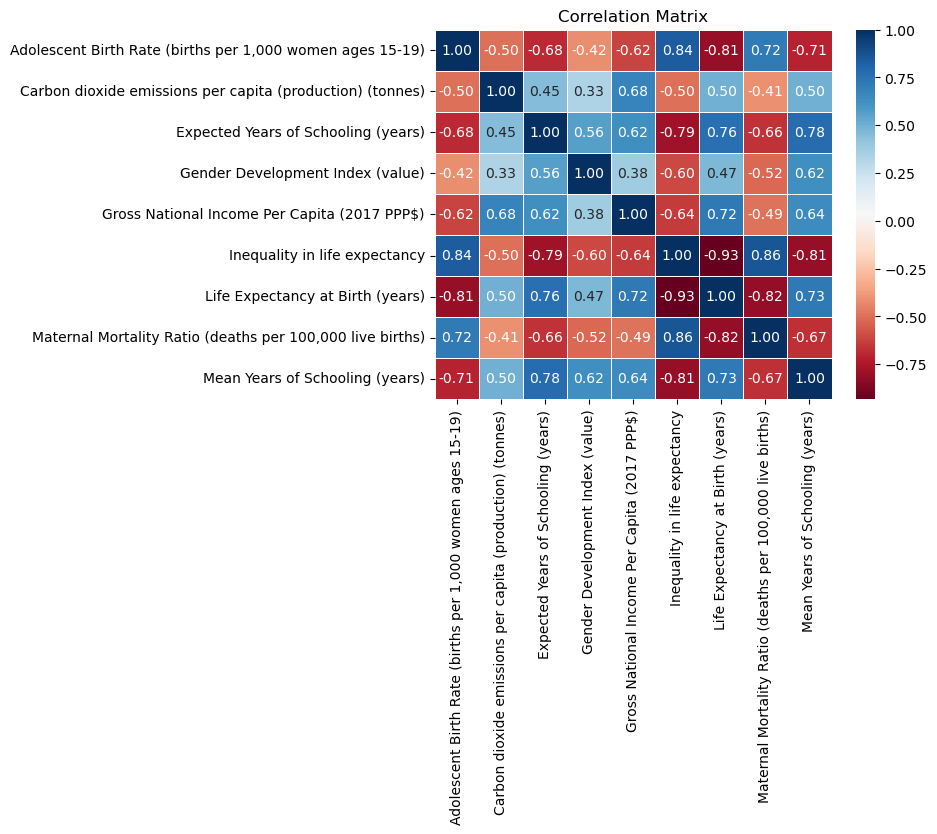

Adolescent Birth Rate (births per 1,000 women ages 15-19)    0.699743
Carbon dioxide emissions per capita (production) (tonnes)    0.540158
Expected Years of Schooling (years)                          0.702436
Gender Development Index (value)                             0.545189
Gross National Income Per Capita (2017 PPP$)                 0.643715
Inequality in life expectancy                                0.774054
Life Expectancy at Birth (years)                             0.749199
Maternal Mortality Ratio (deaths per 100,000 live births)    0.683488
Mean Years of Schooling (years)                              0.717315
dtype: float64

In [35]:
df_features = df_indexed.drop(['Country', 'Code', 'Year'],axis = 1)
corr_matrix = df_features.corr()
corr_matrix
sns.heatmap(corr_matrix, annot=True, cmap='RdBu', fmt='.2f', linewidths=0.4)
plt.title('Correlation Matrix')
plt.show()
corr_matrix.abs().mean()

/Users/shouryayadav/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


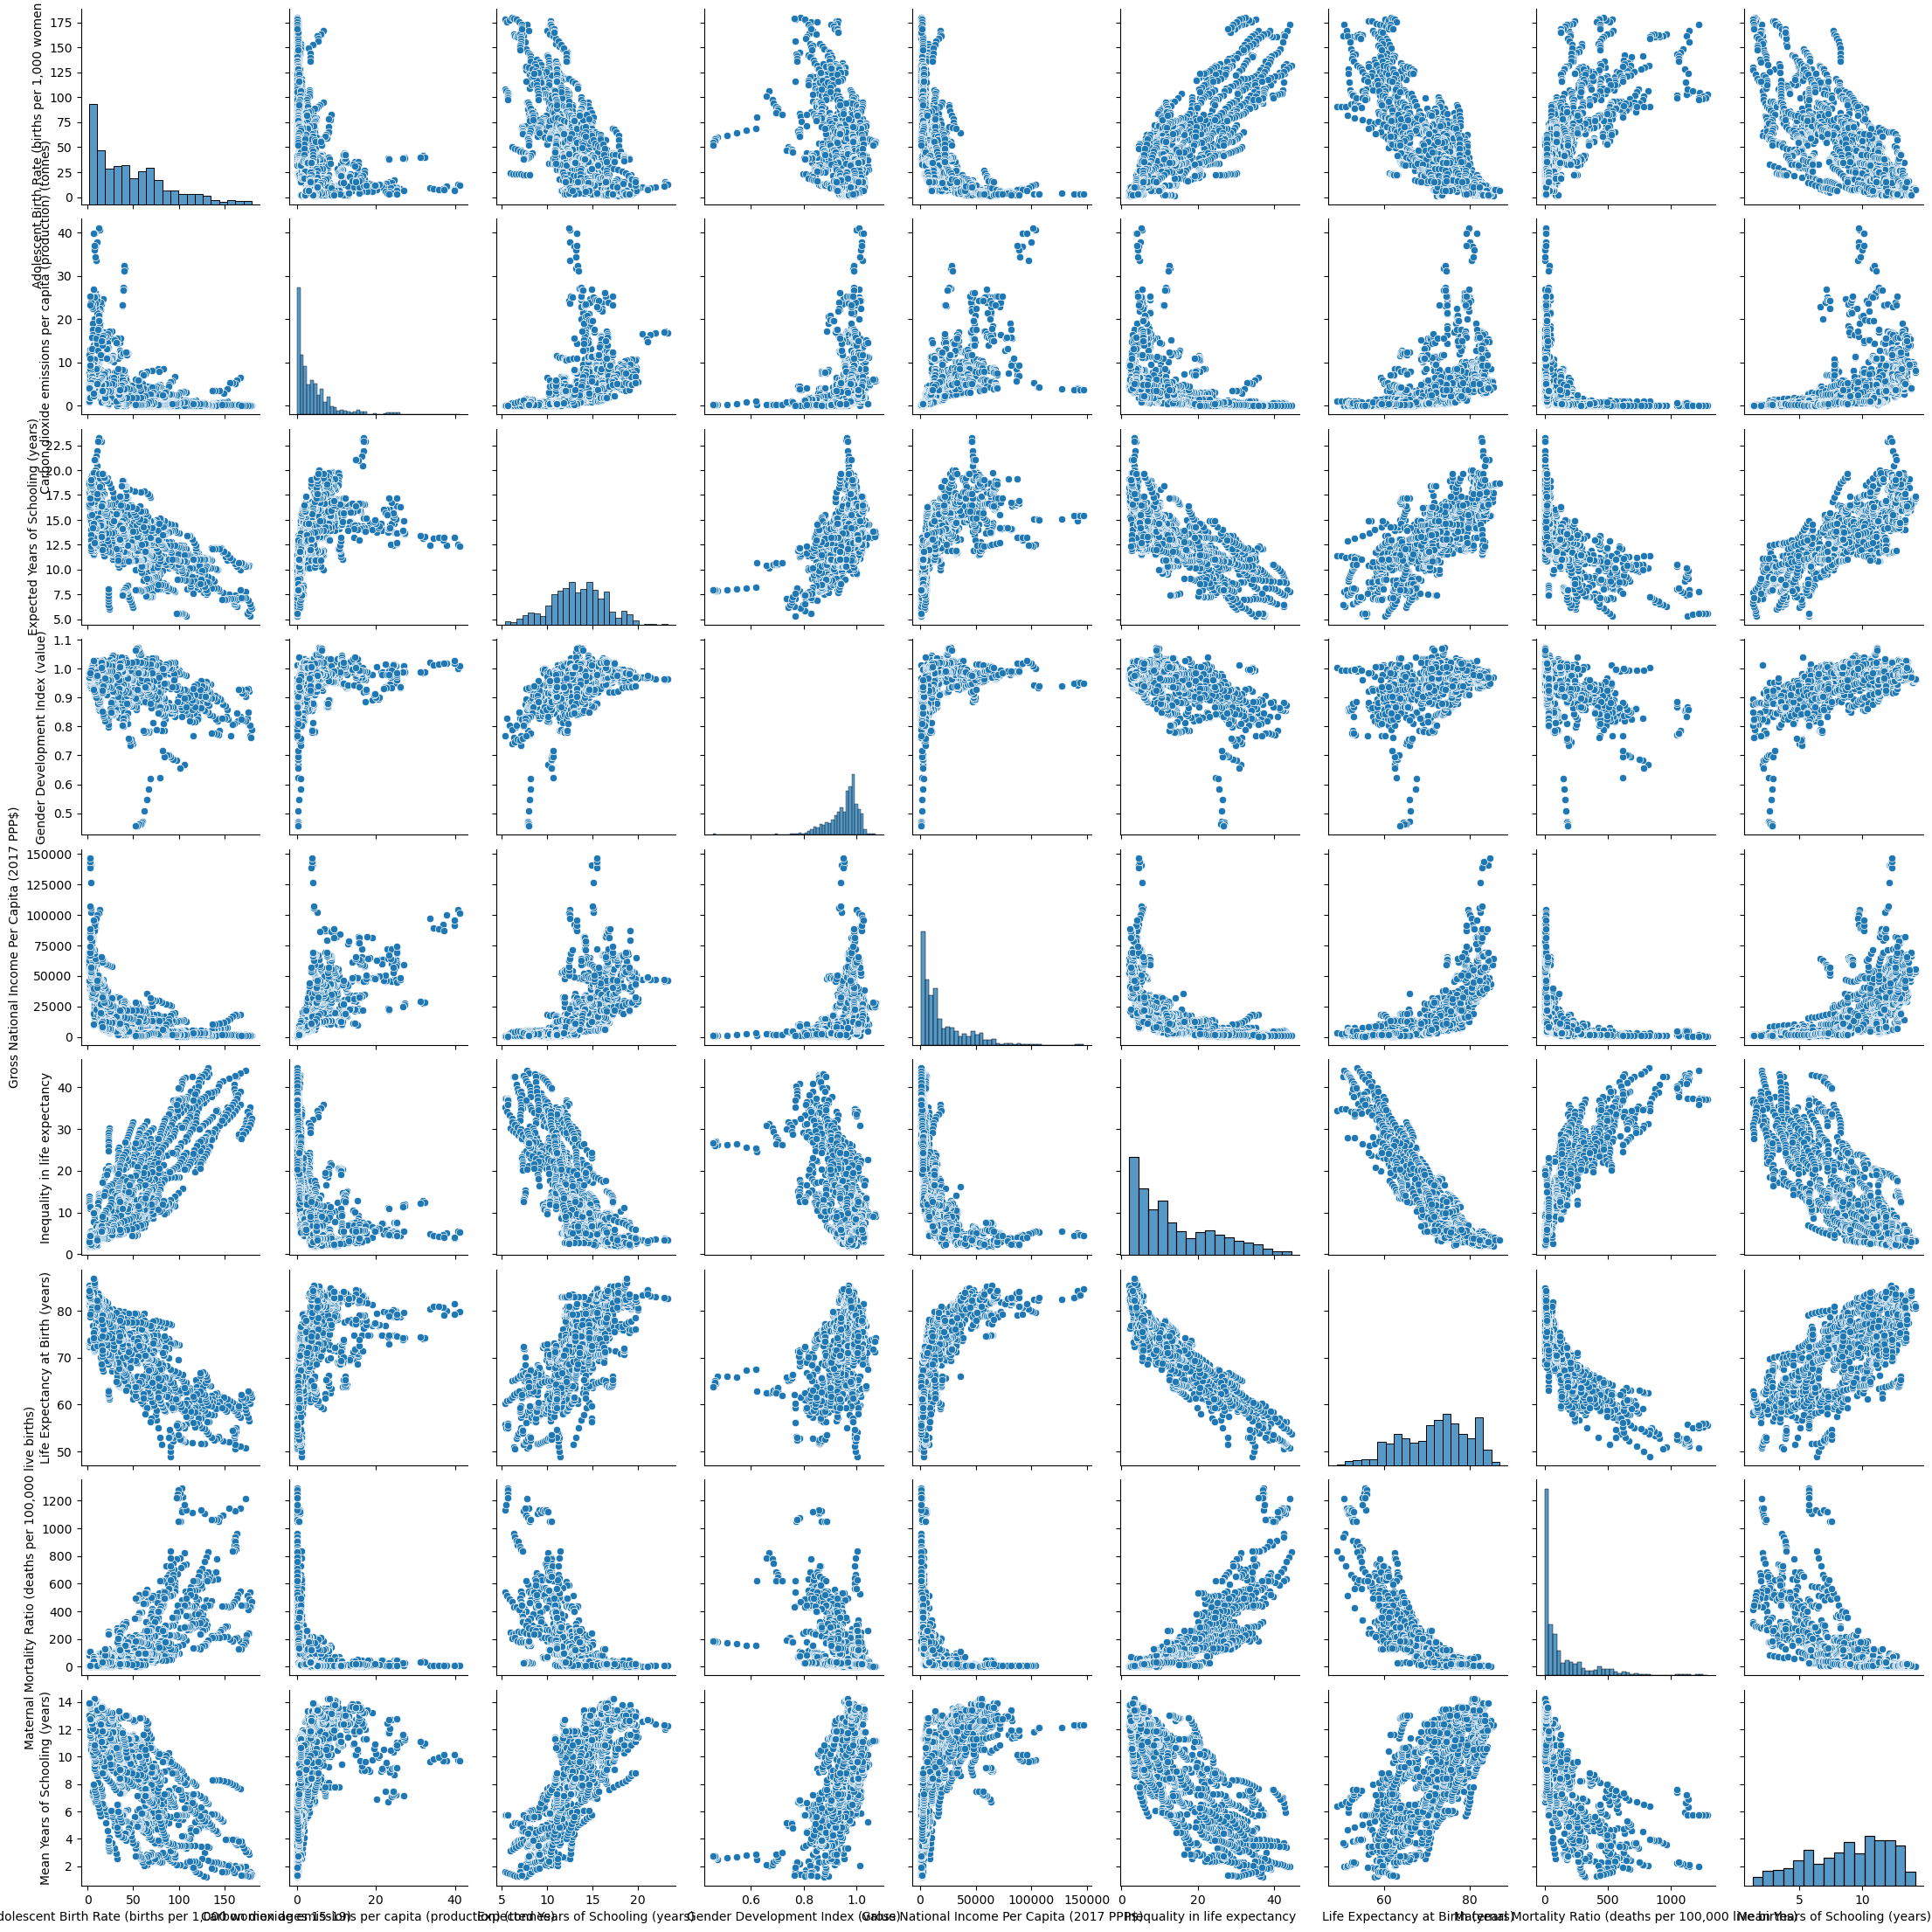

In [36]:
sns.pairplot(df_features)

### Based on the correlation matrix & pairplot above, we should drop "Inequality in life expectancy"

In [38]:
df_clean = df_indexed.drop('Inequality in life expectancy', axis = 1)

In [39]:
df_clean

,Country,Code,Year,"Adolescent Birth Rate (births per 1,000 women ages 15-19)",Carbon dioxide emissions per capita (production) (tonnes),Expected Years of Schooling (years),Gender Development Index (value),Gross National Income Per Capita (2017 PPP$),Life Expectancy at Birth (years),"Maternal Mortality Ratio (deaths per 100,000 live births)",Mean Years of Schooling (years)
23,Afghanistan,AFG,2013,106.537,0.293,10.134,0.667,2244.209,62.417,820.685,2.031
24,Afghanistan,AFG,2014,101.454,0.280,10.465,0.657,2222.094,62.545,785.354,2.077
25,Afghanistan,AFG,2015,97.415,0.290,10.483,0.682,2142.689,62.659,775.693,2.124
26,Afghanistan,AFG,2016,94.018,0.262,10.501,0.685,2122.363,63.136,749.816,2.268
27,Afghanistan,AFG,2017,90.342,0.277,10.520,0.696,2123.676,63.016,681.808,2.411
...,...,...,...,...,...,...,...,...,...,...,...
6434,Zimbabwe,ZWE,2018,98.507,0.712,10.962,0.935,2336.519,61.414,358.504,8.575
6435,Zimbabwe,ZWE,2019,97.354,0.637,10.994,0.928,2156.432,61.292,393.176,8.687
6436,Zimbabwe,ZWE,2020,96.180,0.501,11.026,0.936,1935.506,61.124,356.759,8.808
6437,Zimbabwe,ZWE,2021,94.312,0.525,11.026,0.961,2051.668,59.253,356.759,8.808


## Combining Happiness Data

In [41]:
# Load the combined happiness data
happiness_data = pd.read_csv('combined_happiness_data_filtered.csv')

# Merge the data
happiness_df = pd.merge(
    df_clean,
    happiness_data,
    on=['Country', 'Year'],  # Merge on these columns
    how='inner'  # Use 'inner' to keep only matching rows
)


In [42]:
happiness_df

,Country,Code,Year,"Adolescent Birth Rate (births per 1,000 women ages 15-19)",Carbon dioxide emissions per capita (production) (tonnes),Expected Years of Schooling (years),Gender Development Index (value),Gross National Income Per Capita (2017 PPP$),Life Expectancy at Birth (years),"Maternal Mortality Ratio (deaths per 100,000 live births)",Mean Years of Schooling (years),Happiness Score
0,Afghanistan,AFG,2013,106.537,0.293,10.134,0.667,2244.209,62.417,820.685,2.031,3.572100
1,Afghanistan,AFG,2014,101.454,0.280,10.465,0.657,2222.094,62.545,785.354,2.077,3.130896
2,Afghanistan,AFG,2015,97.415,0.290,10.483,0.682,2142.689,62.659,775.693,2.124,3.982855
3,Afghanistan,AFG,2016,94.018,0.262,10.501,0.685,2122.363,63.136,749.816,2.268,4.220169
4,Afghanistan,AFG,2017,90.342,0.277,10.520,0.696,2123.676,63.016,681.808,2.411,2.661718
...,...,...,...,...,...,...,...,...,...,...,...,...
1005,Zimbabwe,ZWE,2018,98.507,0.712,10.962,0.935,2336.519,61.414,358.504,8.575,3.616480
1006,Zimbabwe,ZWE,2019,97.354,0.637,10.994,0.928,2156.432,61.292,393.176,8.687,3.663000
1007,Zimbabwe,ZWE,2020,96.180,0.501,11.026,0.936,1935.506,61.124,356.759,8.808,3.299200
1008,Zimbabwe,ZWE,2021,94.312,0.525,11.026,0.961,2051.668,59.253,356.759,8.808,3.145000


In [43]:
# Drop rows where 'Happiness Score' is NaN (should be none, since we determined to do so in our parameters above)
happiness_df = happiness_df.dropna(subset=['Happiness Score'])
happiness_df

,Country,Code,Year,"Adolescent Birth Rate (births per 1,000 women ages 15-19)",Carbon dioxide emissions per capita (production) (tonnes),Expected Years of Schooling (years),Gender Development Index (value),Gross National Income Per Capita (2017 PPP$),Life Expectancy at Birth (years),"Maternal Mortality Ratio (deaths per 100,000 live births)",Mean Years of Schooling (years),Happiness Score
0,Afghanistan,AFG,2013,106.537,0.293,10.134,0.667,2244.209,62.417,820.685,2.031,3.572100
1,Afghanistan,AFG,2014,101.454,0.280,10.465,0.657,2222.094,62.545,785.354,2.077,3.130896
2,Afghanistan,AFG,2015,97.415,0.290,10.483,0.682,2142.689,62.659,775.693,2.124,3.982855
3,Afghanistan,AFG,2016,94.018,0.262,10.501,0.685,2122.363,63.136,749.816,2.268,4.220169
4,Afghanistan,AFG,2017,90.342,0.277,10.520,0.696,2123.676,63.016,681.808,2.411,2.661718
...,...,...,...,...,...,...,...,...,...,...,...,...
1005,Zimbabwe,ZWE,2018,98.507,0.712,10.962,0.935,2336.519,61.414,358.504,8.575,3.616480
1006,Zimbabwe,ZWE,2019,97.354,0.637,10.994,0.928,2156.432,61.292,393.176,8.687,3.663000
1007,Zimbabwe,ZWE,2020,96.180,0.501,11.026,0.936,1935.506,61.124,356.759,8.808,3.299200
1008,Zimbabwe,ZWE,2021,94.312,0.525,11.026,0.961,2051.668,59.253,356.759,8.808,3.145000


In [44]:
# Save merged DataFrame
happiness_df.to_csv('final_dataset.csv', index=False)

In [45]:
print(f"Remaining rows before dropping: {happiness_df.shape[0]}")

# Drop rows with missing data in any column
cleaned_df = happiness_df.dropna()

print(f"Remaining rows after dropping: {cleaned_df.shape[0]}")

Remaining rows before dropping: 1010
Remaining rows after dropping: 987


# Machine Learning

## Creating Training and Testing Data

### Functions

In [49]:
def detect_relationship(data, feature, target):
    """
    Determines the best-fitting relationship between a feature and the target: linear, logarithmic, or exponential.

    Parameters:
    - data (pd.DataFrame): The dataset containing the feature and target columns.
    - feature (str): The name of the feature column.
    - target (str): The name of the target column.

    Returns:
    - str: The type of relationship ('linear', 'logarithmic', or 'exponential') that best fits the data.
    """
    X = data[[feature]].copy()
    y = data[target]
    
    relationships = {}

    # Linear Model
    linear_model = LinearRegression()
    linear_model.fit(X, y)
    y_pred_linear = linear_model.predict(X)
    r2_linear = r2_score(y, y_pred_linear)
    relationships['linear'] = r2_linear

    # Logarithmic Model (log of feature)
    if (X[feature] > 0).all():  # Ensure positive values for log transformation
        log_X = np.log(X)
        log_model = LinearRegression()
        log_model.fit(log_X, y)
        y_pred_log = log_model.predict(log_X)
        r2_log = r2_score(y, y_pred_log)
        relationships['logarithmic'] = r2_log
    else:
        relationships['logarithmic'] = float('-inf')

    # Exponential Model (log of target)
    if (y > 0).all():  # Ensure positive values for exponential model
        log_y = np.log(y)
        exp_model = LinearRegression()
        exp_model.fit(X, log_y)
        y_pred_exp = np.exp(exp_model.predict(X))
        r2_exp = r2_score(y, y_pred_exp)
        relationships['exponential'] = r2_exp
    else:
        relationships['exponential'] = float('-inf')  # Invalid option for this target

    # Determine the best relationship based on R²
    best_relationship = max(relationships, key=relationships.get)
    return best_relationship, relationships

def detect_all_relationships(X, y, target_name='Target'):
    """
    Detects the best-fitting relationship type for each feature in X with respect to the target variable y.

    Parameters:
    - X (pd.DataFrame): DataFrame containing the feature columns.
    - y (pd.Series): Series containing the target variable.
    - target_name (str): Name of the target variable (default is 'Target').

    Returns:
    - dict: A dictionary where keys are feature names and values are the best-fitting relationship type.
    """
    # Combine features (X) and target (y) into a single DataFrame
    data = pd.concat([X, y.rename(target_name)], axis=1)

    # Dictionary to store relationships
    relationships = {}

    # Iterate through each feature column
    for feature in X.columns:
        best_relationship, _ = detect_relationship(data, feature, target_name)
        relationships[feature] = best_relationship

    return relationships

def get_relationship_dict(X, y):
    relationship_dict = {}
    
    # Combine the features and target into one DataFrame
    relationship_data = pd.concat([X, y], axis=1)

    for feature in X.columns:
        relationship, scores = detect_relationship(relationship_data, feature, y.name)
        relationship_dict[relationship] = feature
    
    return relationship_dict

def preprocess_data(X, log_features=[], exp_features=[]):
    """
    Preprocess data by applying transformations and scaling.

    Parameters:
    X : pd.DataFrame
        Input dataframe with features to preprocess.
    log_features : list
        Features to apply log(1 + x) transformation.
    exp_features : list
        Features to apply exp(x) transformation.
    Returns:
    np.ndarray
        Scaled NumPy array of the preprocessed features.
    """
    X_transformed = X.copy()
    
    # Log transformation
    X_transformed[log_features] = X[log_features].apply(np.log1p)
    
    # Exponential transformation
    X_transformed[exp_features] = X[exp_features].apply(np.exp)
    
    # Standard scaling
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_transformed)
    
    return X_scaled

### Train Test Split

In [51]:
df_ml = cleaned_df.drop(['Country', 'Code', 'Year'],axis = 1)

#Splitting data into features and target
X = df_ml.drop(columns=['Happiness Score'])  # Features: all columns except the target
y = df_ml['Happiness Score']                 # Target: Happiness Score

#Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#Scaling the Data
X_train_scaled = preprocess_data(X_train)
X_test_scaled = preprocess_data(X_test)

### Identifying and transforming exponential relationships

In [53]:
relationship_data = pd.concat([X, y], axis=1)

relationship_dict = {}
 # Iterate through each feature column
for feature in X.columns:
    relationship, scores = detect_relationship(relationship_data, feature, y.name)
        
 # Append the feature to the appropriate relationship list
    if relationship in relationship_dict:
        relationship_dict[relationship].append(feature)
    else:
        relationship_dict[relationship] = [feature]
relationship_dict

{'logarithmic': ['Adolescent Birth Rate (births per 1,000 women ages 15-19)',
  'Carbon dioxide emissions per capita (production) (tonnes)',
  'Gross National Income Per Capita (2017 PPP$)',
  'Maternal Mortality Ratio (deaths per 100,000 live births)'],
 'linear': ['Expected Years of Schooling (years)'],
 'exponential': ['Gender Development Index (value)',
  'Life Expectancy at Birth (years)',
  'Mean Years of Schooling (years)']}

In [54]:
# Define the features to be transformed
log_features = relationship_dict['logarithmic']
exp_features = relationship_dict['exponential']

# Preprocessin data (includes log, exp transformations, and scaling)
X_train_trans = preprocess_data(X_train, log_features, exp_features)
X_test_trans = preprocess_data(X_test, log_features, exp_features)

## Training some models

### Functions

In [57]:
def train_model(model_type, X_train, y_train, **model_kwargs):
    """
    Train a single model on the provided training data.
    
    Parameters:
    - model_type (str): Type of the model ('linear_regression', 'decision_tree', 'random_forest').
    - X_train, y_train: Training data.
    - model_kwargs: Additional arguments for model initialization.
    
    Returns:
    - model: The trained model.
    """
    if model_type == "linear_regression":
        model = LinearRegression(**model_kwargs)
    elif model_type == "decision_tree":
        model = DecisionTreeRegressor(**model_kwargs)
    elif model_type == "random_forest":
        model = RandomForestRegressor(**model_kwargs)
    elif model_type == "deeap_learning":
        model = RandomForestRegressor(**model_kwargs)
    model.fit(X_train, y_train)
    return model


### Training

In [59]:
lin_model = train_model("linear_regression", X_train_scaled, y_train)
trans_lin_model = train_model("linear_regression", X_train_trans, y_train)
tree_model = train_model("decision_tree", X_train, y_train)
rf_model = train_model("random_forest", X_train, y_train, n_estimators=100,random_state = 42)
models = [rf_model, tree_model, lin_model, trans_lin_model]

## Evaluating these models

### Functions

In [80]:
def linreg_eval(model, X, y, transform=False, cv=5):
    """
    Perform cross-validation with optional transformations.
    
    Parameters:
    -----------
    model : object
        The model to train and evaluate (e.g., LinearRegression, 
        RandomForestRegressor).
    X : pd.DataFrame
        The feature dataset.
    y : array-like
        The target variable.
    transform : bool, default=False
        Whether to apply log and exp transformations during preprocessing.
    cv : int, default=5
        Number of cross-validation folds.
    model_name : str, default="Model"
        Name of the model (for inclusion in the results).
    Returns:
    --------
    metrics : dict
        Cross-validation metrics including RMSE and R² (mean and std).
    """
    y = np.array(y)
    # Lists to store scores
    rmse_scores = []
    r2_scores = []

    # K-Fold cross-validation
    kf = KFold(n_splits=cv, shuffle=True, random_state=42)

    for train_idx, test_idx in kf.split(X):
        # Split data
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        # Preprocess data
        if transform == False:
            X_train_preprocessed = preprocess_data(X_train)
            X_test_preprocessed = preprocess_data(X_test)
        
        else: 
            X_train_preprocessed = preprocess_data(X_train, 
                                               log_features, 
                                               exp_features)
            X_test_preprocessed = preprocess_data(X_test,
                                              log_features, 
                                              exp_features)
        # Train the model
        model.fit(X_train_preprocessed, y_train)

        # Predict and evaluate
        y_pred = model.predict(X_test_preprocessed)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        r2 = r2_score(y_test, y_pred)

        # Store metrics
        rmse_scores.append(rmse)
        r2_scores.append(r2)

    # Compile metrics
    metrics = {
        "CV_RMSE_Mean": np.mean(rmse_scores),
        "CV_RMSE_Std": np.std(rmse_scores),
        "CV_R2_Mean": np.mean(r2_scores),
        "CV_R2_Std": np.std(r2_scores),
    }

    return metrics

def evaluate_model(model, X, y, cv=5):
    """
    Perform cross-validation on a trained model and calculate evaluation metrics.
    
    Parameters:
    - model: The trained model.
    - X, y: Dataset for cross-validation.
    - cv (int): Number of cross-validation folds.
    
    Returns:
    - metrics (dict): Cross-validation metrics (mean and std for RMSE and R²).
    """
    from sklearn.model_selection import cross_val_score

    cv_rmse_scores = -cross_val_score(model, X, y, scoring="neg_root_mean_squared_error", cv=cv)
    cv_r2_scores = cross_val_score(model, X, y, scoring="r2", cv=cv)

    metrics = {
        "CV_RMSE_Mean": np.mean(cv_rmse_scores),
        "CV_RMSE_Std": np.std(cv_rmse_scores),
        "CV_R2_Mean": np.mean(cv_r2_scores),
        "CV_R2_Std": np.std(cv_r2_scores),
    }
    return metrics

def compare_evaluations(results):
    """
    Compare evaluation results for multiple models.
    
    Parameters:
    - results (dict): Dictionary where keys are model names and values are their evaluation metrics.
    
    Returns:
    - comparison_df (pd.DataFrame): Summary DataFrame comparing all models.
    """
    comparison_data = []
    for model_name, metrics in results.items():
        metrics["Model"] = model_name
        comparison_data.append(metrics)
    comparison_df = pd.DataFrame(comparison_data)
    return comparison_df

def plot_rmse(all_metrics):
    """
    Plot the RMSE (CV_RMSE_Mean) of each model.

    Parameters:
    -----------
    all_metrics : dict
        Dictionary containing model names as keys and their evaluation metrics as values.
    """
    # Extract model names and RMSE means
    models = list(all_metrics.keys())
    rmse_means = [metrics["CV_RMSE_Mean"] for metrics in all_metrics.values()]

    # Plotting
    plt.figure(figsize=(10, 6))
    plt.bar(models, rmse_means, alpha=0.8)
    plt.ylabel("CV_RMSE_Mean")
    plt.xlabel("Models")
    plt.title("Cross-Validation RMSE Mean for Each Model")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

### Evaluating and Comparing

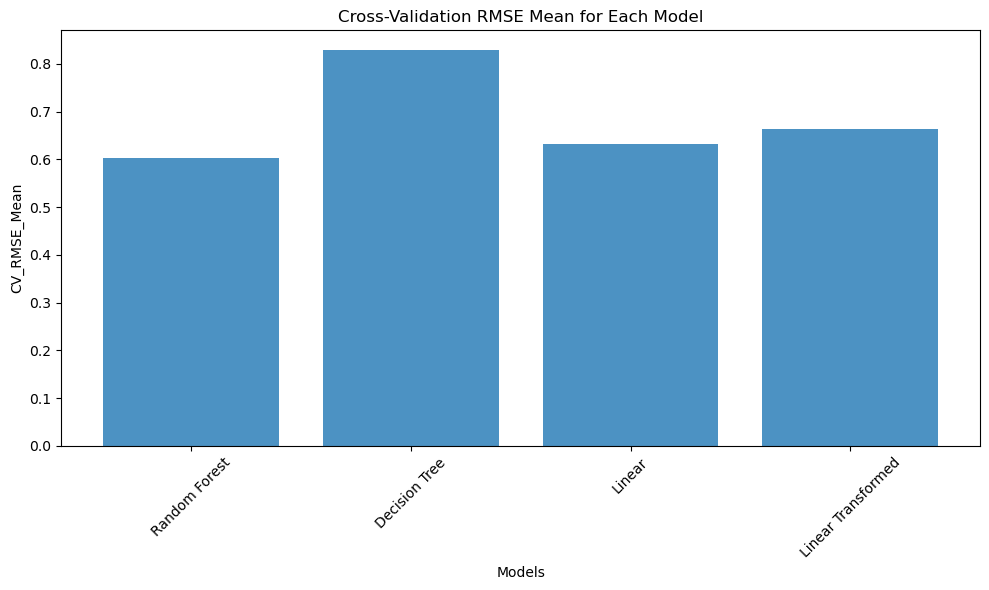

,CV_RMSE_Mean,CV_RMSE_Std,CV_R2_Mean,CV_R2_Std,Model
0,0.603077,0.048047,0.705870,0.048356,Random Forest
1,0.828630,0.091366,0.442131,0.209359,Decision Tree
2,0.632216,0.031015,0.689211,0.025195,Linear
3,0.664041,0.026540,0.657545,0.016534,Linear Transformed


In [82]:
rf_metrics = evaluate_model(rf_model, X, y, cv=5)
tree_metrics = evaluate_model(tree_model, X, y)
linreg_metrics = linreg_eval(lin_model, X, y)
trans_linreg_metrics = linreg_eval(trans_lin_model, X, y, transform = True)

model_names = ["Random Forest","Decision Tree","Linear","Linear Transformed"]
metrics = [rf_metrics,tree_metrics,linreg_metrics,trans_linreg_metrics]
all_metrics = {model_name: metric for model_name, metric in zip(model_names, metrics)}

#Comparing Metrics
plot_rmse(all_metrics)
(compare_evaluations(all_metrics))

## Examining the Weights from each model

### Functions

In [ ]:
def plot_model_feature_importance(model, feature_names, title="Feature Importance"):
    """
    Plot feature importance or coefficients for a Linear Regression, Decision Tree, or Random Forest model.
    
    Parameters:
    -----------
    model: object
        Trained model (LinearRegression, DecisionTreeRegressor, RandomForestRegressor, etc.).
    feature_names: list
        List of feature names corresponding to the input features.
    title: str, default="Feature Importance"
        Title for the plot.
    """

    if hasattr(model, "feature_importances_"):  # Tree-based models
        importances = abs(model.feature_importances_)
        sorted_indices = np.argsort(importances)
        scores = importances[sorted_indices]
        feature_labels = [feature_names[i] for i in sorted_indices]
        xlabel = "Feature Importance"
        color = "seagreen"
        
    elif hasattr(model, "coef_"):  # Linear models
        importances = abs(model.coef_)
        sorted_indices = np.argsort(np.abs(importances))  # Sort by absolute value
        scores = importances[sorted_indices]
        feature_labels = [feature_names[i] for i in sorted_indices]
        xlabel = "Feature Coefficient"
        color = "indianred"

    # Plot
    plt.figure(figsize=(10, 6))
    plt.barh(range(len(scores)), scores, align="center", color = color)
    plt.yticks(range(len(scores)), feature_labels)
    plt.xlabel(xlabel)
    plt.ylabel("Features")
    plt.title(title)
    plt.tight_layout()
    plt.show()

### Plotting the importances

In [ ]:

# Loop through models and model names
for model, model_name in zip(models, model_names):
    # Plot feature importance or coefficients for each model
    print(f"Plotting feature importance for: {model_name}")
    plot_model_feature_importance(model, X.columns, title=f"Feature Importance: {model_name}")


## Predicting Missing Happiness Data

In [ ]:
df_full = merged_df
common_columns = df_full.columns.intersection(df_clean.columns)
df_full = df_full[common_columns].dropna()
prehappy_features = df_full.drop(["Code","Year","Country"], axis = 1)
prehappy_features

In [ ]:
# Predict happiness scores using the Random Forest model
happiness_predictions = rf_model.predict(prehappy_features)

# Create a new DataFrame with predictions
prehappy_predictions = df_full[["Code", "Year", "Country"]].copy()
prehappy_predictions["Predicted Happiness"] = happiness_predictions

# Display the resulting DataFrame
prehappy_predictions

# Visualising and Exploring the Data

### Combine DataFrames for Predicted, Actual, and Difference

In [ ]:
combined_df = prehappy_predictions[["Code", "Year", "Country", "Predicted Happiness"]].merge(
    happiness_df[["Code", "Year", "Happiness Score"]], 
    on=["Code", "Year"],
    how="left" 
)

# Calculate the difference between actual and predicted happiness
combined_df["Happiness Difference"] = combined_df["Happiness Score"] - combined_df["Predicted Happiness"]

# Display the combined DataFrame
combined_df

### Calculate Mean Happiness Per Country Across Years


In [ ]:
mean_happiness_df = combined_df.groupby("Code", as_index=False).agg(
    Mean_Actual_Happiness=("Happiness Score", lambda x: x.dropna().mean()),
    Mean_Predicted_Happiness=("Predicted Happiness", "mean"),
    Mean_Happiness_Difference=("Happiness Difference", lambda x: x.dropna().mean())
)
mean_happiness_df

### Testing the similarity of World predicted vs. World actual happiness

In [ ]:
world_happiness_per_year = combined_df.dropna(subset=["Happiness Score"]).groupby("Year", as_index=False).agg(
    Mean_World_Actual_Happiness=("Happiness Score", "mean"),
    Mean_World_Predicted_Happiness=("Predicted Happiness", "mean"),
    Mean_World_Happiness_Difference=("Happiness Difference", "mean")
)
print('The average difference in predicted vs. actual is:'
      ,world_happiness_per_year.Mean_World_Happiness_Difference.abs().mean())
world_happiness_per_year

### Creating a dataframe of perdicted world happiness over time

In [ ]:
world_predicted_happiness = combined_df.groupby("Year", as_index=False).agg(
    Mean_World_Predicted_Happiness=("Predicted Happiness", "mean")
)
world_predicted_happiness.head()

## Visualisation

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(world_happiness_per_year["Year"], 
         world_happiness_per_year["Mean_World_Actual_Happiness"], 
         label="Actual Happiness", marker="o")

plt.plot(world_happiness_per_year["Year"], 
         world_happiness_per_year["Mean_World_Predicted_Happiness"],
         label="Predicted Happiness", linestyle="--", marker="x")

plt.title("Global Happiness Trends Over Time")
plt.xlabel("Year")
plt.ylabel("Happiness Score")
plt.legend()
plt.grid()
plt.show()

In [ ]:
plt.figure(figsize=(10, 6))

plt.plot(world_predicted_happiness["Year"], 
         world_predicted_happiness["Mean_World_Predicted_Happiness"],
         label="Predicted Happiness", color = "green")

plt.title("Predicted Global Happiness Trends Over Time")
plt.xlabel("Year")
plt.ylabel("Happiness Score")
plt.legend()
plt.grid()
plt.show()

In [ ]:
mean_happiness_sorted = mean_happiness_df.sort_values("Mean_Happiness_Difference")

# Identify top 10 overperformers and underperformers
top_overperformers = mean_happiness_sorted.nlargest(10, "Mean_Happiness_Difference")
top_underperformers = mean_happiness_sorted.nsmallest(10, "Mean_Happiness_Difference")

combined_top_countries = pd.concat([top_overperformers, top_underperformers])

# Plot combined bar graph
plt.figure(figsize=(12, 6))
colors = ["blue" if diff > 0 else "red" for diff in combined_top_countries["Mean_Happiness_Difference"]]
plt.bar(combined_top_countries["Code"], combined_top_countries["Mean_Happiness_Difference"], color=colors)
plt.axhline(0, color="black", linestyle="--", linewidth=0.8)
plt.title("Top 10 Overperforming and Underperforming Countries (Actual - Predicted Happiness)")
plt.xlabel("Country")
plt.ylabel("Happiness Difference")
plt.xticks(rotation=45)
plt.grid(axis="y")
plt.show()

In [ ]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=combined_df.where(combined_df.Year >= 2013),
            x="Year", y="Happiness Score", color="cornflowerblue", width=0.6)
sns.boxplot(data=combined_df.where(combined_df.Year >= 2013),
            x="Year", y="Predicted Happiness", color="salmon", width=0.4)
plt.title("Distribution of Happiness Scores by Year")
plt.xlabel("Year")
plt.ylabel("Happiness Score")
plt.legend(["Actual Happiness", "Predicted Happiness"])
plt.show()

In [ ]:

def create_heatmap(df, country_col, value_col, title="Country Heatmap"):
    """
    Create a heatmap over a world map based on country codes and associated values from a dataframe.
    
    :param df: DataFrame containing the country codes and their corresponding values.
    :param country_col: The column name in the dataframe containing the country codes (ISO 3166-1 alpha-3).
    :param value_col: The column name in the dataframe containing the values (e.g., GDP, Happiness Score, etc.).
    :param title: Title for the heatmap.
    :return: A plotly figure object showing the heatmap on the world map.
    """
    # Load world map data using geopandas
    world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
    
    # Merge world map data with the input dataframe based on country code
    world = world.merge(df, how='left', left_on='iso_a3', right_on=country_col)

    # Plot the heatmap using plotly
    fig = px.choropleth(world, locations='iso_a3', color=value_col,
                        hover_name='name', hover_data=[value_col],
                        title=title)
    
    # Show the plot
    fig.show()
    

create_heatmap(mean_happiness_df, "Code","Mean_Predicted_Happiness",title = "Mean Predicted Happiness Heatmap")
create_heatmap(mean_happiness_df,"Code", "Mean_Actual_Happiness", title = "Mean Actual Happiness Heatmap")
create_heatmap(
    df=mean_happiness_df,
    country_col="Code",  # Replace with the actual column name for country codes
    value_col="Mean_Happiness_Difference",  # Replace with the actual column name for happiness difference
    title="Happiness Performance Heatmap"
)


# Deep Neural Networks

## Basic Model

Epoch 1/50


/Users/shouryayadav/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 22.4769 - val_loss: 2.4120
Epoch 2/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 803us/step - loss: 2.0042 - val_loss: 0.9304
Epoch 3/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.7053 - val_loss: 0.6929
Epoch 4/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 944us/step - loss: 0.6057 - val_loss: 0.5799
Epoch 5/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 888us/step - loss: 0.5699 - val_loss: 0.5291
Epoch 6/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 747us/step - loss: 0.4300 - val_loss: 0.4796
Epoch 7/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 757us/step - loss: 0.4673 - val_loss: 0.4487
Epoch 8/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 754us/step - loss: 0.4445 - val_loss: 0.3956
Epoch 9/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 797us/step - loss: 0.4120 - val_loss: 0.3648
Epoch 10/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 789us/step - loss: 0.3641 - val_loss: 0.3812
Epoch 11/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 825us/step - loss: 0.3222 - val_loss: 0.3376
Epoch 12/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 783us/step - loss: 0.296

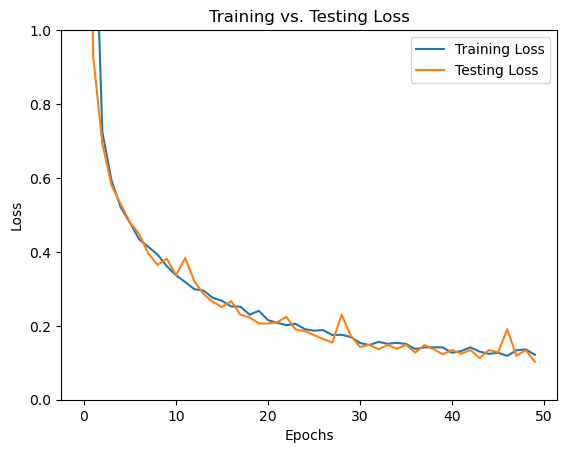

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 766us/step
Validation Metrics:
Mean Squared Error (MSE): 0.1033
Root Mean Squared Error (RMSE): 0.3213
R² Score: 0.9102


In [104]:
df = cleaned_df.drop(['Country', 'Code', 'Year'], axis = 1)
X = df.drop(columns=['Happiness Score'])
y = df['Happiness Score']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

model = tf.keras.Sequential([
    tf.keras.layers.Dense(48, input_dim=X_train_scaled.shape[1], activation='relu'), 
    tf.keras.layers.Dense(32, activation='relu'), 
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(1) 
])
model.compile(optimizer='adam', loss='mean_squared_error')
history = model.fit(X_train_scaled, y_train, epochs=50, batch_size=10, validation_data=(X_test_scaled, y_test))

y_train_pred = model.predict(X_train_scaled)
y_test_pred = model.predict(X_test_scaled)

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Testing Loss')
plt.title('Training vs. Testing Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.ylim(0, 1)
plt.savefig('fiftyepochsonly.png')
plt.legend()
plt.show()

# Metrics for Performance etc.
y_pred = model.predict(X_test_scaled)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)
print("Validation Metrics:")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"R² Score: {r2:.4f}")

## Cross-Validated Model

Epoch 1/50


/Users/shouryayadav/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 24.7223 - val_loss: 3.0225
Epoch 2/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2.3975 - val_loss: 1.0900
Epoch 3/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 774us/step - loss: 0.8376 - val_loss: 0.7415
Epoch 4/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 717us/step - loss: 0.6392 - val_loss: 0.5899
Epoch 5/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 757us/step - loss: 0.6007 - val_loss: 0.5184
Epoch 6/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 714us/step - loss: 0.5085 - val_loss: 0.4544
Epoch 7/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 714us/step - loss: 0.4526 - val_loss: 0.3974
Epoch 8/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 732us/step - loss: 0.4153 - val_loss: 0.3620
Epoch 9/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 720us/step - loss: 0.4164 - val_loss: 0.3381
Epoch 10/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 719us/step - loss: 0.3785 - val_loss: 0.3046
Epoch 11/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 748us/step - loss: 0.3616 - val_loss: 0.2823
Epoch 12/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 739us/step - loss: 0.333

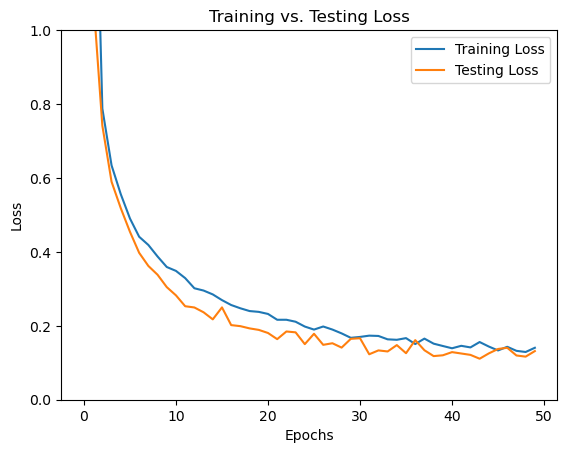

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Validation Metrics:
Mean Squared Error (MSE): 0.1316
Root Mean Squared Error (RMSE): 0.3628
R² Score: 0.8855


In [107]:
df = cleaned_df.drop(['Country', 'Code', 'Year'], axis = 1)
X = df.drop(columns=['Happiness Score'])
y = df['Happiness Score']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

model = tf.keras.Sequential([
    tf.keras.layers.Dense(48, input_dim=X_train_scaled.shape[1], activation='relu'), 
    tf.keras.layers.Dense(32, activation='relu'), 
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(1) 
])
model.compile(optimizer='adam', loss='mean_squared_error')
history = model.fit(X_train_scaled, y_train, epochs=50, batch_size=10, validation_data=(X_test_scaled, y_test))

y_train_pred = model.predict(X_train_scaled)
y_test_pred = model.predict(X_test_scaled)

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Testing Loss')
plt.title('Training vs. Testing Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.ylim(0, 1)
plt.savefig('fiftyepochsonly.png')
plt.legend()
plt.show()

# Metrics for Performance etc.
y_pred = model.predict(X_test_scaled)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)
print("Validation Metrics:")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"R² Score: {r2:.4f}")

## Experiment: A Fake Country

In [109]:
# Prediction for fake_country
fake_country = pd.DataFrame({
    'Adolescent Birth Rate (births per 1,000 women ages 15-19)': [6],
    'Carbon dioxide emissions per capita (production) (tonnes)': [8],
    'Expected Years of Schooling (years)': [18],
    'Gender Development Index (value)': [0.98],
    'Gross National Income Per Capita (2017 PPP$)': [40000],
    'Life Expectancy at Birth (years)': [82],
    'Maternal Mortality Ratio (deaths per 100,000 live births)': [8],
    'Mean Years of Schooling (years)': [12],
})

fake_country_scaled = scaler.transform(fake_country)
predicted_happiness_score = model.predict(fake_country_scaled)

print(f"Predicted Happiness Score for fake country: {predicted_happiness_score[0][0]}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Predicted Happiness Score for fake country: 6.537740707397461


In [86]:
fake_country # Fake country data line visualized

,"Adolescent Birth Rate (births per 1,000 women ages 15-19)",Carbon dioxide emissions per capita (production) (tonnes),Expected Years of Schooling (years),Gender Development Index (value),Gross National Income Per Capita (2017 PPP$),Life Expectancy at Birth (years),"Maternal Mortality Ratio (deaths per 100,000 live births)",Mean Years of Schooling (years)
0,6,8,18,0.98,40000,82,8,12


## A Fake Country Across A Range Of Values


### Range of Incomes

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━

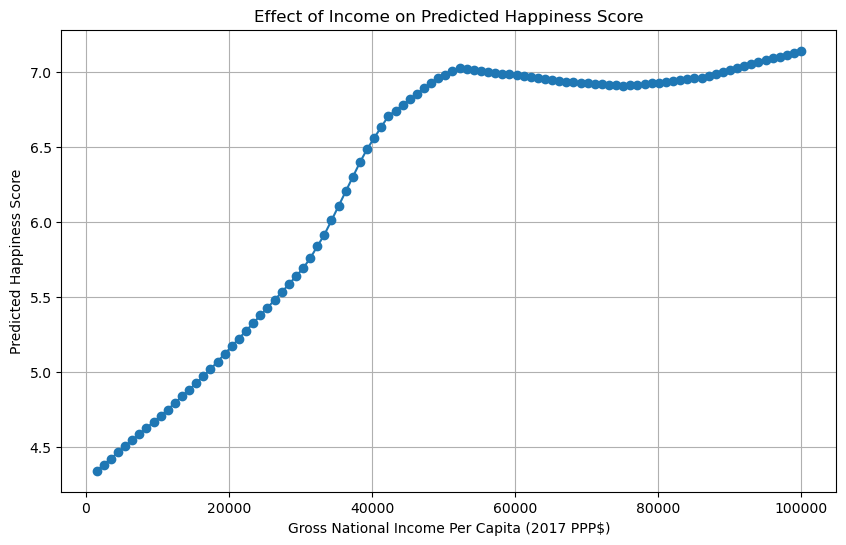

In [111]:
# Create a range of income values from the current value to 100,000
income_values = np.linspace(1500, 100000, num=100)

# Initialize an array to store predicted happiness scores
happiness_scores = []

# Use the fake_country data as a template
fake_country_template = fake_country.copy()

for income in income_values:
    # Update the income in the fake_country template
    fake_country_template['Gross National Income Per Capita (2017 PPP$)'] = income
    
    # Scale the data
    fake_country_scaled = scaler.transform(fake_country_template)
    
    # Predict happiness score for the updated data
    predicted_score = model.predict(fake_country_scaled)
    happiness_scores.append(predicted_score[0][0])

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(income_values, happiness_scores, marker='o', linestyle='-')
plt.title("Effect of Income on Predicted Happiness Score")
plt.xlabel("Gross National Income Per Capita (2017 PPP$)")
plt.ylabel("Predicted Happiness Score")
plt.grid(True)
plt.show()

### Range of Educations

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━

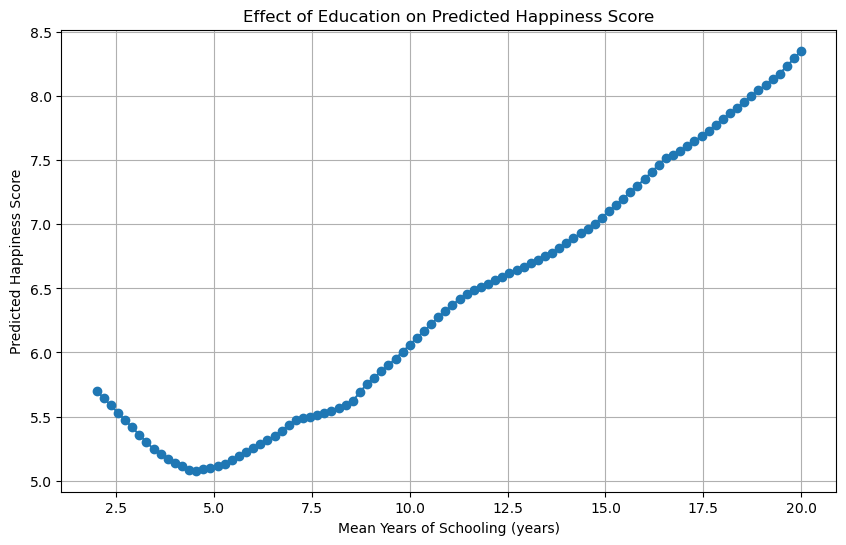

In [120]:

# Create a range of income values from the current value to 100,000
income_values = np.linspace(2, 20, num=100)

# Initialize an array to store predicted happiness scores
happiness_scores = []

# Use the fake_country data as a template
fake_country_template = fake_country.copy()

for income in income_values:
    # Update the income in the fake_country template
    fake_country_template['Mean Years of Schooling (years)'] = income
    
    # Scale the data
    fake_country_scaled = scaler.transform(fake_country_template)
    
    # Predict happiness score for the updated data
    predicted_score = model.predict(fake_country_scaled)
    happiness_scores.append(predicted_score[0][0])

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(income_values, happiness_scores, marker='o', linestyle='-')
plt.title("Effect of Education on Predicted Happiness Score")
plt.xlabel("Mean Years of Schooling (years)")
plt.ylabel("Predicted Happiness Score")
plt.grid(True)
plt.show()